**Handwritten Equation Solver Using CNN(MobileNetV2)**

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

**Importing Dataset File**

In [ ]:
!kaggle datasets download -d clarencezhao/handwritten-math-symbol-dataset

Dataset URL: https://www.kaggle.com/datasets/clarencezhao/handwritten-math-symbol-dataset
License(s): copyright-authors
handwritten-math-symbol-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


**Unzipping the Dataset File**

In [ ]:
import zipfile
zip=zipfile.ZipFile("/content/handwritten-math-symbol-dataset.zip","r")
zip.extractall('/content')
zip.close()

**Importing Necessary Required Libraries**

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)

2.15.0


In [ ]:
train_dir=Path("/content/train")
train_filepaths=list(train_dir.glob(r'**/*.jpg'))

In [ ]:
test_dir=Path("/content/eval")
test_filepaths=list(test_dir.glob(r'**/*.jpg'))

**Preproccessing the Images in the the Folder**

In [ ]:
import pandas as pd

def image_processing(filepaths):
    # Ensure all filepaths are converted to strings
    filepaths = [str(filepath) for filepath in filepaths]

    # Extract labels from filepaths
    labels = [str(filepath).split("/")[-2] for filepath in filepaths]

    # Create a DataFrame with filepaths and labels
    df = pd.DataFrame({'Filepath': filepaths, 'Label': labels})

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop=True)

    return df


In [ ]:
train_df=image_processing(train_filepaths)
test_df=image_processing(test_filepaths)

In [ ]:
print("---Trainig Set---\n")
print(f"Number of Images: {train_df.shape[0]}\n")
print(f"Number of different labels: {len(train_df.Label.unique())}\n")
print(f"Labels: {train_df.Label.unique()}")

---Trainig Set---

Number of Images: 7557

Number of different labels: 16

Labels: ['nine' 'equal' 'four' 'times' 'one' 'two' 'minus' 'three' 'plus cleaned'
 'eight' 'five' 'zero' 'div' 'seven' 'decimal' 'six']


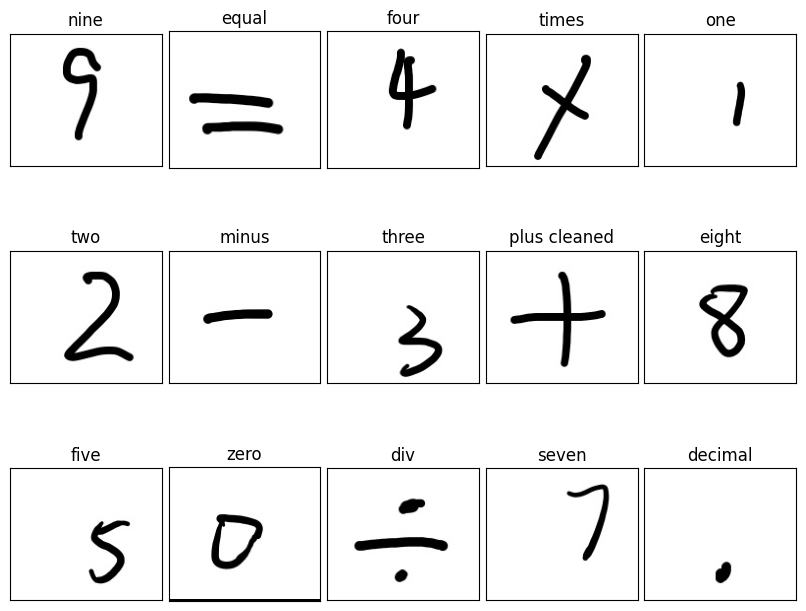

In [ ]:
#Create a DataFrame with one label of each category
df_unique=train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

#Displaying Some Images of the dataset
fig,axes=plt.subplots(nrows=3,ncols=5,figsize=(8,7),subplot_kw={'xticks':[],'yticks':[]})

for i,ax in enumerate(axes.flat):
  ax.imshow(plt.imread(df_unique.Filepath[i]))
  ax.set_title(df_unique.Label[i],fontsize=12)

plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
train_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
#Training the image to create a new image and identify(Data Augmentation)
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,  # Corrected parameter name
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)


Found 7557 validated image filenames belonging to 16 classes.


In [ ]:
#Testing the image to test a new image and identify
test_images = train_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=0,
)


Found 1010 validated image filenames belonging to 16 classes.


In [ ]:
pretrained_model=tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
    pooling='avg',
)
pretrained_model.trainable=False

**CNN Model using MobileNetV2**

In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
inputs = pretrained_model.input

x = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.001))(pretrained_model.output)
x = tf.keras.layers.Dropout(0.5)(x)  # Add dropout after a dense layer to avoid overfitting

x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001))(pretrained_model.output)
x = tf.keras.layers.Dropout(0.5)(x)  # Add dropout after a dense layer
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))(pretrained_model.output)
x = tf.keras.layers.Dropout(0.5)(x)  # Add dropout after a dense layer

x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001))(pretrained_model.output)

outputs = tf.keras.layers.Dense(16, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=test_images,
    batch_size = 32,
    epochs=4

    ,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/4
237/237 [==============================] - 28s 72ms/step - loss: 0.6261 - accuracy: 0.9098 - val_loss: 0.3505 - val_accuracy: 0.9713
Epoch 2/4
237/237 [==============================] - 15s 62ms/step - loss: 0.3009 - accuracy: 0.9722 - val_loss: 0.2649 - val_accuracy: 0.9713
Epoch 3/4
237/237 [==============================] - 14s 58ms/step - loss: 0.2342 - accuracy: 0.9760 - val_loss: 0.2264 - val_accuracy: 0.9792
Epoch 4/4
237/237 [==============================] - 14s 58ms/step - loss: 0.1753 - accuracy: 0.9880 - val_loss: 0.1998 - val_accuracy: 0.9703


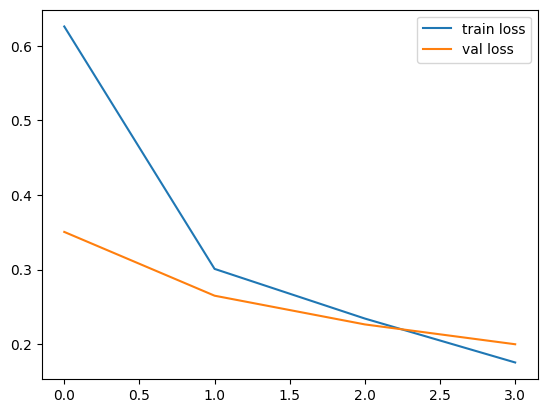

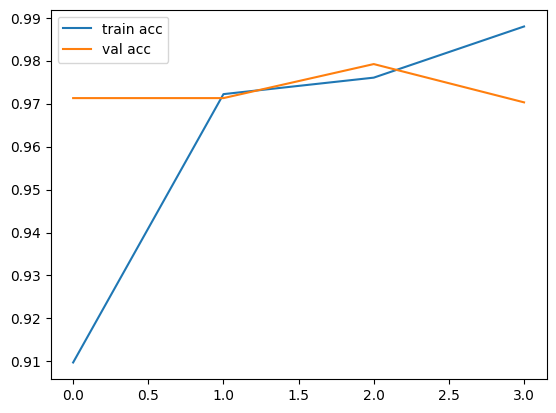

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
model.save("my_modified_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model

model = load_model("my_modified_model.h5")

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

32/32 [==============================] - 2s 49ms/step


['two',
 'five',
 'times',
 'decimal',
 'five',
 'times',
 'nine',
 'equal',
 'minus',
 'three',
 'two',
 'nine',
 'decimal',
 'one',
 'five',
 'one',
 'zero',
 'six',
 'seven',
 'times',
 'six',
 'six',
 'minus',
 'minus',
 'three',
 'decimal',
 'eight',
 'plus cleaned',
 'nine',
 'minus',
 'one',
 'six',
 'four',
 'div',
 'times',
 'six',
 'seven',
 'minus',
 'eight',
 'times',
 'plus cleaned',
 'times',
 'decimal',
 'five',
 'five',
 'five',
 'minus',
 'one',
 'nine',
 'decimal',
 'minus',
 'decimal',
 'four',
 'zero',
 'seven',
 'times',
 'one',
 'six',
 'nine',
 'four',
 'one',
 'plus cleaned',
 'three',
 'two',
 'decimal',
 'zero',
 'eight',
 'five',
 'eight',
 'minus',
 'div',
 'one',
 'equal',
 'eight',
 'decimal',
 'zero',
 'minus',
 'equal',
 'three',
 'one',
 'five',
 'seven',
 'six',
 'plus cleaned',
 'one',
 'five',
 'eight',
 'times',
 'div',
 'zero',
 'decimal',
 'plus cleaned',
 'times',
 'two',
 'one',
 'minus',
 'minus',
 'minus',
 'five',
 'six',
 'five',
 'div',
 'p

In [ ]:


from tensorflow.keras.preprocessing.image import load_img, img_to_array

def output(location, model):
    img = load_img(location, target_size=(224, 224, 3))
    img = img_to_array(img)
    img = img / 255
    img = np.expand_dims(img, axis=0)
    answer = model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res


1/1 [==============================] - 2s 2s/step
The Predicted Digit is five.


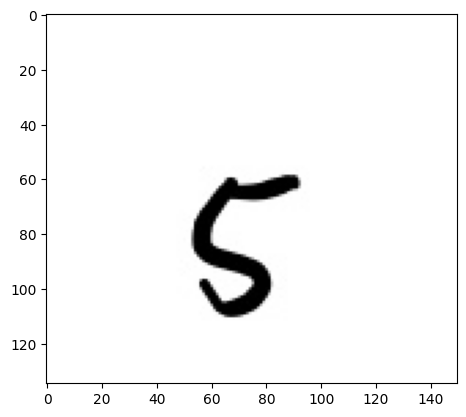

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import cv2

test_img= cv2.imread("/content/eval/five/11067.jpg")
plt.imshow(test_img)

pred=output("/content/eval/five/11067.jpg", model)

print(f"The Predicted Digit is {pred}.")


**Returning Integer Value To Predicted Images Labels**

In [ ]:
def strToSymbol(pred):
    if pred == "zero":
        return 0
    elif pred == "one":
        return 1
    elif pred == "two":
        return 2
    elif pred == "three":
        return 3
    elif pred == "four":
        return 4
    elif pred == "five":
        return 5
    elif pred == "six":
        return 6
    elif pred == "seven":
        return 7
    elif pred == "eight":
        return 8
    elif pred == "nine":
        return 9
    elif pred == "plus cleaned":
        return '+'
    elif pred == "minus":
        return '-'
    elif pred == "div":
        return '/'
    elif pred == "equal":
        return '='
    elif pred == "decimal":
        return '.'
    elif pred == "times":
        return '*'


**Predictive Sytsem to Solve Equation from Image Prediction**

1/1 [==============================] - 0s 21ms/step


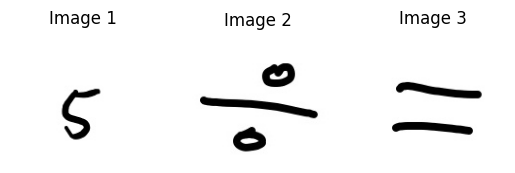

Recognized Equation: 5 / =
Solution: Error: invalid syntax (<string>, line 1)


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import cv2
import matplotlib.pyplot as plt

# Function to predict the label for an image
def predict_label(image_path):
    # Loading the image and make a prediction
    test_img = cv2.imread(image_path)
    pred = output(image_path,model)  # Prediction function
    return pred

# Function to recognize labels and create an equation
def recognize_and_solve_equation(images):
    equation = []
    combined_digits = ""

    for img_path in images:
        label = predict_label(img_path)
        if label.isdigit():
            combined_digits += label
        else:
            if combined_digits:
                equation.append(combined_digits)
                combined_digits = ""
            equation.append(label)

    if combined_digits:
        equation.append(combined_digits)

    # Convert labels to symbols
    equation = [strToSymbol(label) for label in equation if label]

    # Handle multi-digit and decimal numbers
    updated_equation = []
    for item in equation:
        if isinstance(item, int) or isinstance(item, float):
            if updated_equation and isinstance(updated_equation[-1], (int, float)):
                updated_equation[-1] = updated_equation[-1] * 10 + item
            else:
                updated_equation.append(item)
        else:
            updated_equation.append(item)

    # Join elements with spaces to form a string
    equation_str = ' '.join(map(str, updated_equation))

    return equation_str

# Function to calculate the result of the equation
def calculate_result(equation_str):
    try:
        if '=' in equation_str:
            parts = equation_str.split('=')
            if len(parts) == 2:
                result_left = eval(parts[0])
                result_right = eval(parts[1])
                return result_left == result_right
            else:
                return "Error: Invalid equation format"
        else:
            result = eval(equation_str)
            return result
    except ZeroDivisionError:
        return "Error: Division by zero"
    except Exception as e:
        return "Error: " + str(e)

# List of image paths for the equation elements
image_paths = [
        "/content/eval/five/11067.jpg",
        "/content/eval/div val/1120.jpg",
        "/content/eval/equal val/1499.jpg",

]

# Recognize equation and solve
equation_str = recognize_and_solve_equation(image_paths)
result = calculate_result(equation_str)

# Displaying the input images
fig, axs = plt.subplots(1, len(image_paths))
for i, img_path in enumerate(image_paths):
    img = cv2.imread(img_path)
    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[i].set_title(f"Image {i + 1}")
    axs[i].axis('off')

plt.show()

print("Recognized Equation:", equation_str)
print("Solution:", result)


In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.1 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import cv2
import numpy as np
import io
from pathlib import Path
import os.path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Load the modified model
model = load_model("my_modified_model.h5")


train_dir=Path("/content/train")
train_filepaths=list(train_dir.glob(r'**/*.jpg'))
test_dir=Path("/content/eval")
test_filepaths=list(test_dir.glob(r'**/*.jpg'))

def image_processing(filepaths):
    # Ensure all filepaths are converted to strings
    filepaths = [str(filepath) for filepath in filepaths]

    # Extract labels from filepaths
    labels = [str(filepath).split("/")[-2] for filepath in filepaths]

    # Create a DataFrame with filepaths and labels
    df = pd.DataFrame({'Filepath': filepaths, 'Label': labels})

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop=True)

    return df


train_df=image_processing(train_filepaths)
test_df=image_processing(test_filepaths)

train_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

#Training the image to create a new image and identify(Data Augmentation)
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,  # Corrected parameter name
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

#Testing the image to test a new image and identify
test_images = train_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=0,
)


# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())

def output(location, model):
    img = load_img(location, target_size=(224, 224, 3))
    img = img_to_array(img)
    img = img / 255
    img = np.expand_dims(img, axis=0)
    answer = model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

# Function to convert image to io.BytesIO
def convert_image_to_bytesio(image):
    _, buffer = cv2.imencode('.jpg', image)
    bytesio = io.BytesIO(buffer)
    return bytesio

def crop_digits_contours(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply adaptive thresholding
    binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on area and aspect ratio
    min_area = 100
    aspect_ratio_range = (0.5, 2.0)
    filtered_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / h
        if area > min_area and aspect_ratio_range[0] < aspect_ratio < aspect_ratio_range[1]:
            filtered_contours.append(contour)

    # Sort contours by x-coordinate
    contours = sorted(filtered_contours, key=lambda c: cv2.boundingRect(c)[0])

    cropped_images = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cropped_image = image[y:y+h, x:x+w]
        cropped_images.append(cropped_image)

    return cropped_images


# Function to predict the label for a segment
def predict_label(segment):
    bytesio = convert_image_to_bytesio(segment)
    # Implement your prediction logic using the output function
    label = output(bytesio,model)
    return label

# Function to convert predicted label string to symbol
def str_to_symbol(pred):
    symbol_mapping = {
        "zero": '0',
        "one": '1',
        "two": '2',
        "three": '3',
        "four": '4',
        "five": '5',
        "six": '6',
        "seven": '7',
        "eight": '8',
        "nine": '9',
        "plus cleaned": '+',
        "minus": '-',
        "div": '/',
        "equal": '=',
        "decimal": '.',
        "times": '*'
    }
    return symbol_mapping.get(pred, pred)

# Custom CSS for styling
css_style = """
<style>
    body {
        background-image: url('https://up.yimg.com/ib/th?id=OIP.CmAW3DzcY3ARa_ClUfhE1QHaEK&pid=Api&rs=1&c=1&qlt=95&w=203&h=114');
        background-size: cover;
        font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
        color: white;
    }
    .stApp {
        background-color: transparent;
    }
    .stButton>button {
        background-color: black;
        color: white;
        font-weight: bold;
        border-radius: 5px;
        padding: 10px 20px;
        cursor: pointer;
        transition: background-color 0.3s;
    }
    .stButton>button:hover {
        background-color: #333333;
    }
    .stButton>button:active {
        background-color: black;
        box-shadow: 0 2px #666;
        transform: translateY(4px);
    }
    .stTextInput>div>div>label,
    .stNumberInput>div>div>label,
    .stSelectbox>div>div>label {
        background-color: black;
        padding: 8px 12px;
        border-radius: 5px;
        font-weight: bold;
        font-size: 16px;
    }
    /* Updated CSS for heading */
    .heading-text {
        background-color: rgba(0, 0, 0, 0.8);
        color: white;
        padding: 10px 20px;
        border-radius: 5px;
        font-weight: bold;
        font-size: 24px;
        text-align: center;
    }
    /* Custom style for success and info messages */
    .stSuccess, .stInfo {
        background-color: rgba(0, 0, 0, 0.8);
        color: white;
        padding: 10px;
        border-radius: 5px;
        font-weight: bold;
        font-size: 16px;
        text-align: center;
    }
</style>
"""

# Display the CSS styling
st.markdown(css_style, unsafe_allow_html=True)

# Streamlit UI
# Heading with custom CSS class
st.markdown('<p class="heading-text">HandwrittenEquationSolver</p>', unsafe_allow_html=True)

# Upload image
uploaded_file = st.file_uploader("Upload Image", type=["png", "jpg", "jpeg"])

def process_and_predict(image):
    cropped_digits = crop_digits_contours(image)
    predicted_labels = []
    for i, digit in enumerate(cropped_digits):
        label = predict_label(digit)
        symbol = str_to_symbol(label)
        predicted_labels.append(symbol)
    equation_str = ''.join(predicted_labels)
    try:
        result = eval(equation_str)
        solution = f"The solution of the equation is: {result}"
    except SyntaxError:
        solution = "Invalid expression. Please enter a valid arithmetic expression."
    except NameError:
        solution = "Invalid variable used in the expression. Please only use numeric values."
    except Exception as e:
        solution = f"Error occurred during evaluation: {str(e)}"
    return equation_str, solution


# Display image, predict equation, and show solution on button click
if uploaded_file is not None:
    image = cv2.imdecode(np.fromstring(uploaded_file.read(), np.uint8), 1)
    st.image(image, caption='Uploaded Image', use_column_width=True)
    if st.button('Predict Equation and Evaluate', key="predict_button"):
        with st.spinner('Predicting and Evaluating...'):
            equation, solution = process_and_predict(image)
            st.markdown(f'<p class="stSuccess">Predicted Equation: {equation}</p>', unsafe_allow_html=True)
            st.markdown(f'<p class="stInfo">{solution}</p>', unsafe_allow_html=True)

Overwriting app.py


In [ ]:
! wget -q -O - ipv4.icanhazip.com

35.197.79.237


In [ ]:
! streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://35.197.79.237:8501

npx: installed 22 in 1.945s
your url is: https://violet-cows-chew.loca.lt
2024-05-03 14:36:40.956324: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 14:36:40.956378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 14:36:40.957793: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-03 14:36:42.084731: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-05-03 14:36:43.749236